In [27]:
# Imports, as always...
from pathlib import Path
import time
import copy
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split as tts
from torch.utils.data import DataLoader
from scripts.data import QuantumDataset

import torch
import torch.nn as nn
from torch.optim import Adam
from scripts.training import train, evaluate

import warnings
warnings.filterwarnings('ignore')

seed = 42
torch.random.manual_seed(seed)

test_split, val_split = .2, .2

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
import seaborn as sns
import cmcrameri.cm as cmc
palette = 'deep'
sns.set_theme(style='darkgrid', palette=palette)

In [5]:
# Raw data.
raw_data = pd.concat([
    pd.read_csv(data_csv) 
    for data_csv in Path('./data/depth-varied').glob('*.csv')
], ignore_index=True)

# Subset for between devices of the same type:
subset_same = raw_data[raw_data['device'] != 'Aria-1'].replace({'Ankaa-3':0, 'Garnet':1})
# Subset for between devices of differing type:
subset_diff = raw_data[raw_data['device'] != 'Garnet'].replace({'Ankaa-3':0, 'Aria-1':1})

In [6]:
in_features = {'raw' : 32, 'res' : 32, 'abs_res' : 32, 'rel_res' : 32, 'abs_rel_res' : 32, 'log_ratio' : 32, 'qubit_res' : 5, 'abs_qubit_res' : 5, 'pauli_z_res' : 5, 'pauli_zz_res' : 10
}

In [7]:
# Helper function to create a balanced subset for two devices.
def stratified_sample(df, n, device_a_label=0, device_b_label=1, random_state=None):
    # Split into device 0 and device 1.
    df_0 = df[df['device'] == device_a_label]
    df_1 = df[df['device'] == device_b_label]
    
    # Too large an n?
    assert n <= len(df_0) and n <= len(df_1), 'n must be smaller than each dataset.'

    # Sample.
    sample_0 = df_0.sample(n=n, random_state=random_state)
    sample_1 = df_1.sample(n=n, random_state=random_state)
    
    # Combine and shuffle the result
    result = pd.concat([sample_0, sample_1]).sample(frac=1, random_state=random_state).reset_index(drop=True)
    
    return result

## Same-type Classification

Epoch 115/200 | Train Loss: 0.3451 | Train Acc: 0.8516 | Val Loss: 0.4695 | Val Acc: 0.7922


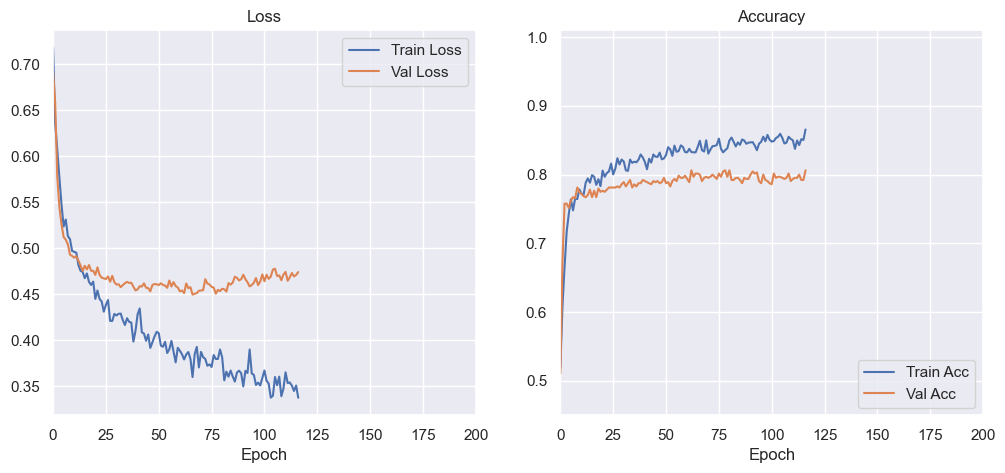

(0.45652509927749635, 0.78875)

In [22]:
# Datasets.
feature_type = 'raw'
dataset = QuantumDataset(subset_same[subset_same['d'] < 25], feature_type)
train_set, test_set = tts(dataset, test_size=test_split, shuffle=True, random_state=seed)
train_set, val_set = tts(train_set, test_size=val_split, shuffle=True, random_state=seed)

# Dataloaders.
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# Model.
model = nn.Sequential(
    nn.Linear(in_features[feature_type], 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(64, 16), nn.BatchNorm1d(16), nn.ReLU(), nn.Dropout(.5),
    nn.Linear(16, 2)
)
model.to(device)

# Train.
_ = train(
    model,
    train_loader,
    val_loader,
    Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
    epochs=200,
    verbose=True,
    patience=50,
    min_delta=1e-5
)

# Test.
evaluate(model, test_loader)

In [24]:
def experiment_run(data_df, feature_type):
    # Datasets.
    dataset = QuantumDataset(data_df, feature_type)
    train_set, test_set = tts(dataset, test_size=test_split, shuffle=True, random_state=seed)
    train_set, val_set = tts(train_set, test_size=val_split, shuffle=True, random_state=seed)
    
    # Dataloaders.
    batch_size = 64
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    
    # Model.
    model = nn.Sequential(
        nn.Linear(in_features[feature_type], 256), nn.BatchNorm1d(256), nn.ReLU(), nn.Dropout(.5),
        nn.Linear(256, 64), nn.BatchNorm1d(64), nn.ReLU(), nn.Dropout(.5),
        nn.Linear(64, 2)
    )
    model.to(device)
    
    # Train.
    _, train_accs, _, val_accs = train(
        model,
        train_loader,
        val_loader,
        Adam(model.parameters(), lr=1e-3, weight_decay=1e-4),
        epochs=500,
        verbose=False,
        patience=75,
        min_delta=1e-5
    )
    
    # Test.
    _, test_acc = evaluate(model, test_loader)
    
    return max(train_accs), max(val_accs), test_acc

In [25]:
results_at_d = {}
results_up_to_d = {}

for feature_type in tqdm(in_features.keys()):
    results_at_d[feature_type] = {}
    results_up_to_d[feature_type] = {}
    
    for d in [5, 10, 15, 20]:
        results_at_d[feature_type][d] = experiment_run(subset_same[subset_same['d'] == d], feature_type)
        results_up_to_d[feature_type][d] = experiment_run(subset_same[subset_same['d'] <= d], feature_type)
        
results_at_d, results_up_to_d

  0%|          | 0/10 [00:00<?, ?it/s]

({'raw': {5: (0.9796875, 0.89375, 0.875),
   10: (0.9953125, 0.90625, 0.9),
   15: (0.990625, 0.89375, 0.89),
   20: (0.971875, 0.875, 0.87)},
  'res': {5: (0.9484375, 0.7125, 0.685),
   10: (0.9, 0.58125, 0.51),
   15: (0.8796875, 0.60625, 0.595),
   20: (0.8671875, 0.56875, 0.525)},
  'abs_res': {5: (0.9453125, 0.675, 0.635),
   10: (0.8859375, 0.60625, 0.605),
   15: (0.8828125, 0.55625, 0.525),
   20: (0.85625, 0.5125, 0.49)},
  'rel_res': {5: (0.66875, 0.6, 0.545),
   10: (0.6609375, 0.5125, 0.49),
   15: (0.6671875, 0.59375, 0.505),
   20: (0.646875, 0.53125, 0.535)},
  'abs_rel_res': {5: (0.66875, 0.54375, 0.58),
   10: (0.6359375, 0.5125, 0.5),
   15: (0.6546875, 0.5875, 0.495),
   20: (0.659375, 0.575, 0.54)},
  'log_ratio': {5: (0.9609375, 0.7875, 0.775),
   10: (0.9296875, 0.7, 0.585),
   15: (0.85625, 0.6, 0.505),
   20: (0.859375, 0.55625, 0.53)},
  'qubit_res': {5: (0.775, 0.75625, 0.685),
   10: (0.6828125, 0.5375, 0.505),
   15: (0.6703125, 0.58125, 0.555),
   20: (0.63

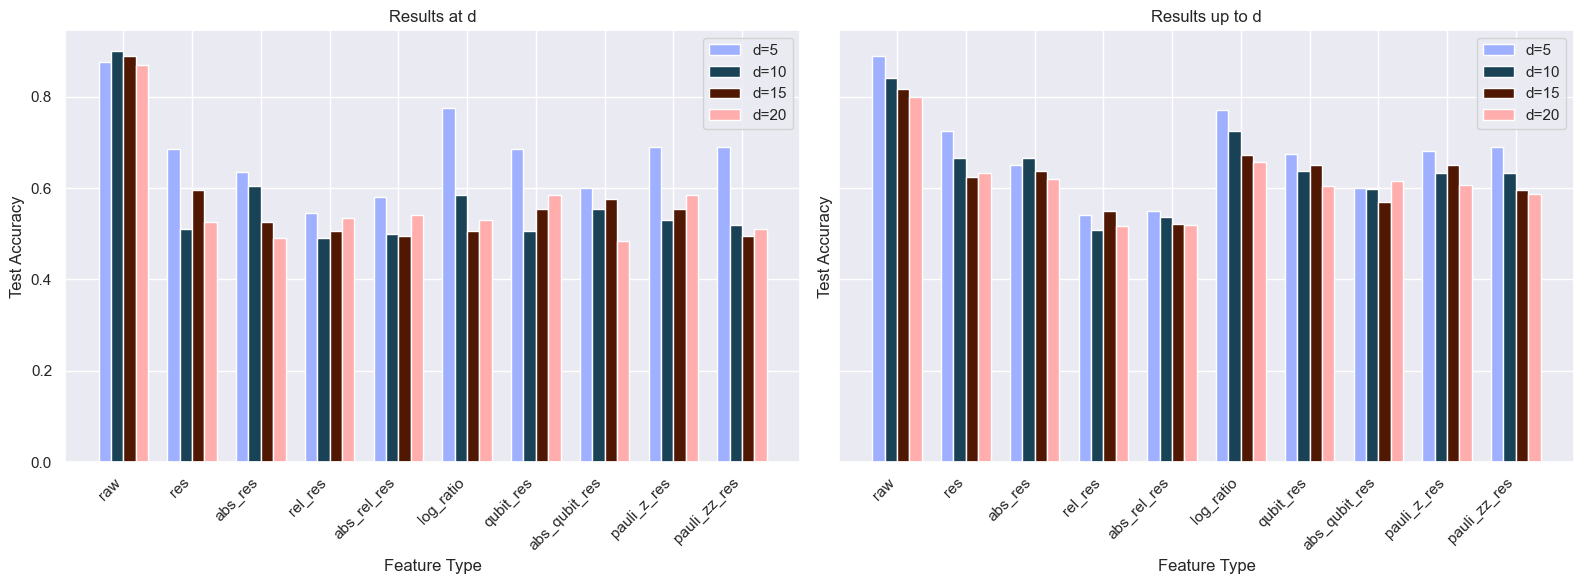

In [28]:
# Settings
d_values = [5, 10, 15, 20]
features = list(in_features.keys())
n_features = len(features)
n_d = len(d_values)

cmap = cmc.berlin
colors = [cmap(i / (n_d - 1)) for i in range(n_d)]
bar_width = 0.18

def extract_test_acc(results):
    data = np.zeros((n_features, n_d))
    for i, feature in enumerate(features):
        for j, d in enumerate(d_values):
            _, _, test_acc = results[feature][d]
            data[i, j] = test_acc
    return data

data_at_d = extract_test_acc(results_at_d)
data_up_to_d = extract_test_acc(results_up_to_d)

x = np.arange(n_features)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

for ax, data, title in zip(
    axes,
    [data_at_d, data_up_to_d],
    ["Results at d", "Results up to d"]
):
    for j, d in enumerate(d_values):
        ax.bar(
            x + j * bar_width,
            data[:, j],
            width=bar_width,
            label=f"d={d}",
            color=colors[j],
        )

    ax.set_xticks(x + bar_width * (n_d - 1) / 2)
    ax.set_xticklabels(features, rotation=45, ha="right")
    ax.set_title(title)
    ax.set_xlabel("Feature Type")
    ax.set_ylabel("Test Accuracy")
    ax.legend()

plt.tight_layout()
plt.show()